# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

23699

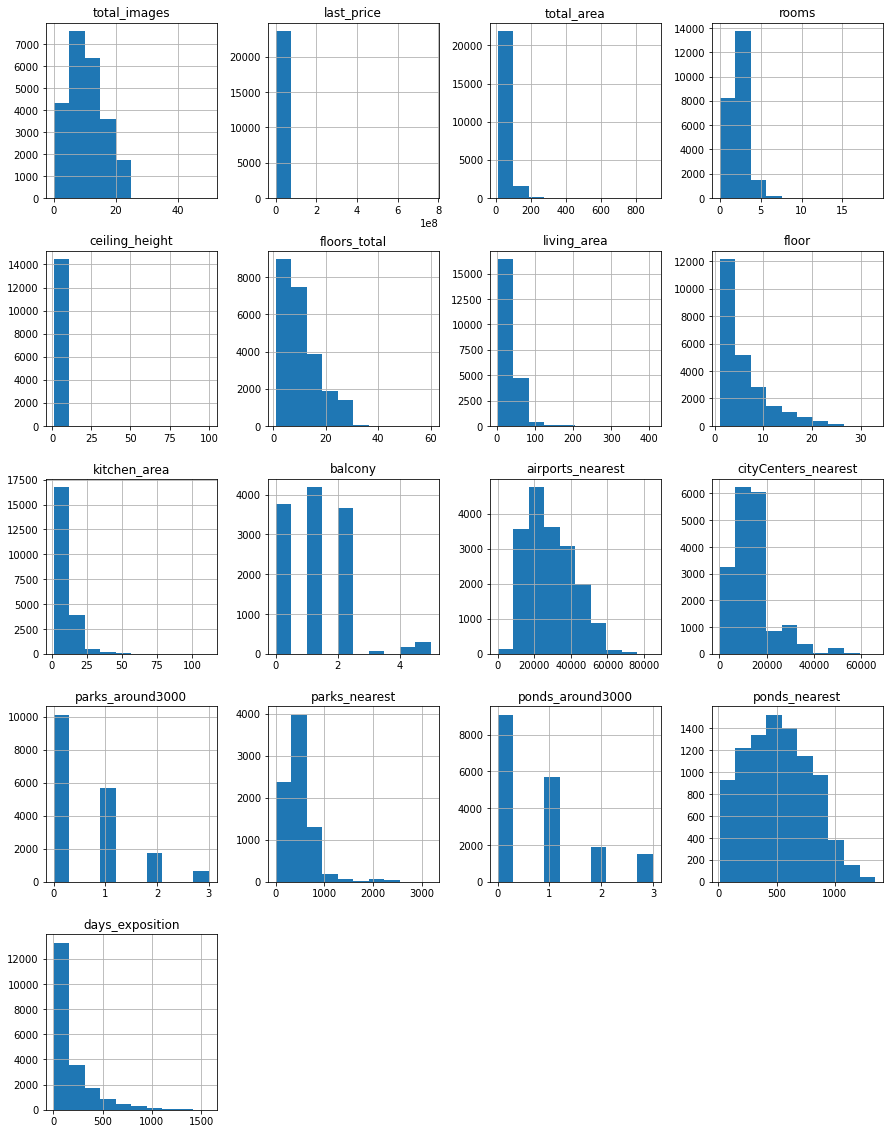

In [1]:
import pandas as pd
import datetime
import numpy as np

df=pd.read_csv('/datasets/real_estate_data.csv',sep='\t') #скачка файла
df.head(20)
df.info() #общая информация о данных
df.hist(figsize=(15, 20))
df.shape[0]

### Предобработка данных

In [2]:
df.isna().sum()#просмотр пропусков по столбцам
columns_to_replace = ['balcony','parks_around3000','ponds_around3000'] # заполняем нулями пропуски в столбце 'balcony','parks_around3000','ponds_around3000' циклом
for element in columns_to_replace: 
    df[element] = df[element].fillna(value=0)
df['locality_name']=df['locality_name'].fillna(value='без названия') #заполняем пропуски в 'locality_name'
columns_to_retype = ['balcony','parks_around3000','ponds_around3000','last_price','floors_total','days_exposition','airports_nearest','cityCenters_nearest','parks_nearest','ponds_nearest']
for vid in columns_to_retype: 
    df[vid]=pd.to_numeric(df[vid], downcast='integer',errors='coerce')

df['is_apartment']=df['is_apartment'].astype('bool')  #меняем тип данных по апартаментам на bool
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S') #меняем тип данных по дате

#обработка пропусков по высоте потолков
df = df.dropna(subset=['floors_total'])
for f in df['floors_total'].unique():
    df.loc[(df['floors_total'] == f) & (df['ceiling_height'].isna()), 'ceiling_height'] = df.loc[(df['floors_total'] == f), 'ceiling_height'].median()

#заполняем пропуски по площади объекта с помощью медианных значений
coefficient_living_area = (df['living_area'] / df['total_area']).mean()
df.loc[(df['living_area'].isna()), 'living_area'] = df.loc[(df['living_area'].isna()), 'total_area'] * coefficient_living_area

    
#df.head(20) 
#df['locality_name'].unique()





/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [3]:
#df.isna().sum()

# для проверки гипотезы - "недвижимость с пропусками в floors_total одноэтажная?" - НЕ ПОДТВЕРЖДЕНА
#df['floors_total'].unique()
#df.query('floors_total not in [ 16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., 20.,28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.]')

# проверка гипотезы, что у студий человек не указывал размер кухни отдельно, так как она совмещена с комнатой - ПОДТВЕРЖДЕНА
#df.query('studio==True and kitchen_area>0') таких объектов нет в данных

#неявные дубликаты в названиях населённых пунктов

#df['locality_name'].value_counts()
#df['locality_name'].unique() - оцениваем уникальные наименования

df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('посёлок','поселок', regex=True)   
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('городской','', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('городского','', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('типа','', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('имени','', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('станции','', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('при железнодорожной','', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('садовое товарищество','СНТ', regex=True) 
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('садововедческое некоммерческое товарищество','СНТ', regex=True) 

df['locality_name'].unique()

#df['locality_name'].duplicated().sum()
#df.duplicated().sum() проверка дублированных строк в данных
#df.shape[0]

array(['Санкт-Петербург', 'поселок Шушары', ' поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок   Красный Бор', 'Гатчина', 'деревня Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок   Лебяжье', 'поселок   Сиверский',
       'поселок Молодцово', 'поселок   Кузьмоловский', 'СНТ Новая Ропша',
       'Павловск', 'деревня Пикколово', 'Всеволожск', 'Волхов',
       'Кингисепп', 'Приозерск', 'Сестрорецк', 'деревня Куттузи',
       'поселок Аннино', 'поселок   Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зеленогорск', 'Сосн

Причины, которые могли привести к пропускам в данных: технические ошибки, человеческий фактор. Например, системе не удалось распознать living_area на карте. Общее количество этажей пропущено явно в связи с тем, что человек этот параметр случайно не указал. Аналогично с наличием балкона, так как его отсутствие зачастую больше негативный фактор для соискателей. Точную высоту потолков человек мог не знать. Парки и водоемы (важные параметры) в радиусе 3км могут отсутствовать, поэтому человек не указывал их наличие в объявлении, поэтому их можно свести к нулю. Точное расстояние до центра города (особенно живя в поселке), ближайших парков и водоемов, аэропорта человек тоже может не знать. Касаемо кухни: человек мог не знать точный размер или на объекте (например, студии) кухня совмещена с жилой комнатой, поэтому отдельно ее размер не вынесли. Пропуски в графе апартаменты получились из-за неправильного типа данных в столбце.

Показатели, у которых должен быть другой тип данных (int вместо float, так как необходимы целые значения): last_price - цена на момент снятия с публикации, floors_total — всего этажей в доме, balcony — число балконов, ponds_around3000 — число водоёмов в радиусе 3 км, parks_around3000 — число парков в радиусе 3 км, days_exposition — сколько дней было размещено объявление (от публикации до снятия), parks_nearest — расстояние до ближайшего парка (м),airports_nearest — расстояние до ближайшего аэропорта в метрах (м),cityCenters_nearest — расстояние до центра города (м), parks_nearest — расстояние до ближайшего парка (м),ponds_nearest — расстояние до ближайшего водоёма (м).

Дополнительно: is_apartment — апартаменты (из object в bool аналогично с studio, open_plan) и first_day_exposition — дата публикации (из object к типу "дата")

In [4]:
#Работа с аномалиями

#df.columns
#df.isnull().sum()

Было обнаружено, что в 'ceiling_height' сомнительная высота 25, 100... Было также найдено 5 объектов с высотой потолков менее 2м. А в 'kitchen_area' слишком большая площадь. В 'last_price' была найдена аномалия - низкая цена 12190 за двухкомнатные апартаменты. После проверки строки среза с данным показателям было решено не удалять срез, а заменить значение цены на среднее в схожих апартаментах при условии 100<общая площадь<125, 2 комнаты, последний этааж. В жил площади были найдены строки, где значения меньше 5 м^2 причем просто умножив на 10 не удаось бы восстановить рациональность в данных, поэтому было решено удаоить строки с данной аномалией. В airports_nearest было найдено аномальное расстояние 0м, рпедпринята попытка сбросить значение. В общем количестве этажей было найдено аномальное значеие 60 у объекта в Кронштадте, которого явно не существует, сократил значение в 10 раз.

In [5]:
col = ['total_images', 'last_price', 'total_area',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony',
       'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']

for i in col:
    print(df[i].unique())
#  в 'ceiling_height' сомнительная высота 25, 100...  А в 'kitchen_area' большая площадь. Уменьшим в 10 раз аномалии

#df['total_images'].unique() - в картинках аномалий не нашлось, хотя некоторые объекты выставлены без фото
#df['ceiling_height'].unique()
#df['kitchen_area'].unique()
#df.query('ceiling_height<2')
df = df[df.ceiling_height > 2] # удаляем строки с аномально низкими потолками (5 шт)
df.loc[(df.ceiling_height >= 10), 'ceiling_height'] = df['ceiling_height']/10
df.drop(labels = [15061,22309],axis = 0,inplace=True)
df.drop(labels = [22869],axis = 0,inplace=True) #удаляем строку с высотой потолков 10 м
df.loc[(df.kitchen_area >= 30), 'kitchen_area'] = df['kitchen_area']/10



#не удалось сделать дополнительное условие к размеру кухни
#df.query('kitchen_area >= living_area') 
#for i in range(len(df)):
    #if df.loc[df['kitchen_area']] >= df.loc[df['living_area']]:
       # df.drop([i], axis = 0, inplace = True)

#проверка цены на аномалии
#df['last_price'].sort_values(ascending=True)
#df.query('last_price==12190') - аномально низкая цена на объект

price_12=df.query('100<total_area<125 and rooms==2 and floor==floors_total and is_apartment==True')
print(price_12['last_price'].mean())
df['last_price'] = np.where((df.last_price <= 20000), 12320263, df.last_price) #заменил на среднее значение в максимально схожих апартаментах
#df.loc[(df.last_price <= 20000), 'last_price'] = 12320263

#df.loc[df['last_price']==12190]=price_12['last_price'].mean() #неудачная попытка того же

#проверка общей площади на аномалии
#df['total_area'].sort_values(ascending=True)   

#проверка этажей на аномалии
# df.query('floors_total<floor')
#df.query('floors_total==1')

#df.query('floors_total>50')
#df.loc[df['floors_total']==60]['locality_name'] # найдено аномально высокое здание
df.loc[(df.floors_total == 60), 'floors_total'] = df['floors_total']/10

# проверка жил площади на аномалии
df = df[df.living_area > 5]
#не помню, как корректно удалять строки с определенным условием, поэтому взял этот легкий путь
#df['living_area'].sort_values(ascending=True)
#df.query('living_area<10')
#df.query('living_area>total_area or kitchen_area>total_area')

#проверка дней до снятия объявления на аномалии
#df.sort_values(by='days_exposition',ascending=True)   

#проверка аномальных расстояний
#df.query('airports_nearest<=0 or cityCenters_nearest<=0 or ponds_nearest<=0 or parks_nearest<=0')
#df.loc[(df.airports_nearest == 0), 'airports_nearest'] = np.nan - не удалось сбросить ноль такой командой
#df.query('parks_around3000<=0 or ponds_around3000<=0')
#df.query('parks_around3000<=0 and parks_nearest<=3000')
#df.query('ponds_around3000<=0 and ponds_nearest<=3000')

#df.query('rooms<1') #заполнить в студиях комнату единицами
df['rooms'] = np.where((df.rooms == 0) & (df.total_area<=100), 1, df.rooms)

#for r in round(df['total_area']):
   # df.loc[(df['total_area'] == r) & (df['rooms']==0)] = df.loc[(df['total_area'] == r), 'rooms'].median()
#df.shape[0]
#df.head(20)

#df.query('total_area>500')
df.drop(labels = [19540],axis = 0,inplace=True) #удаляем строку с выбросом по площади (900м^2)
df.drop(labels = [19392],axis = 0,inplace=True) #удаляем строку без информации о комнатах и площади кухни, площадь слишком большая для студии, ничего не сделать
df.drop(labels = [14498,18848],axis = 0,inplace=True) #удаляем строки с выбросом по комнатам (16 и 19 слишком много)
df.drop(labels = [12971],axis = 0,inplace=True) #удаляем строку с выбросом по цене (763 млн ту мач)

df.shape[0]

[20  7 10  0  2  6  5 18  9  1 16 11  8 12 13  3 15 17 14 19 32  4 35 39
 23 21 27 30 24 25 28 31 22 29 26 50 42 37]
[13000000  3350000  5196000 ...  6151120 21400000 11475000]
[108.    40.4   56.   ...  66.86 133.81  76.75]
[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
[  2.7    2.75   2.55   2.6    3.03   2.65   2.66   2.5    2.67   2.56
   3.     3.05   2.8    2.9    3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7   14.85   2.52   5.2    2.87   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8   

23585

### Посчитайте и добавьте в таблицу новые столбцы

In [6]:
df['m2_price']=df['last_price']/df['total_area'] #цена одного квадратного метра
df['day_of_week_exposition']= df['first_day_exposition'].dt.weekday #день недели публикации
df['month_exposition']=df['first_day_exposition'].dt.month #месяц публикации
df['year_exposition']=df['first_day_exposition'].dt.year # год публикации

def fl(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_type'] = df.apply(fl, axis=1) #тип этажа
df['cityCenters_km']=round(df['cityCenters_nearest']/1000) # расстояние до центра города в км



### Проведите исследовательский анализ данных

count    2.358500e+04
mean     6.486111e+06
std      9.332120e+06
min      4.300000e+05
25%      3.408000e+06
50%      4.650000e+06
75%      6.799000e+06
max      4.013000e+08
Name: last_price, dtype: float64
count    23585.000000
mean        60.265224
std         35.023437
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        631.200000
Name: total_area, dtype: float64
count    23585.000000
mean         2.077846
std          1.054507
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         15.000000
Name: rooms, dtype: float64
count    23585.000000
mean         2.708948
std          0.245088
min          1.485000
25%          2.550000
50%          2.650000
75%          2.750000
max          8.300000
Name: ceiling_height, dtype: float64
count    23585.000000
mean        10.669451
std          6.585484
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        

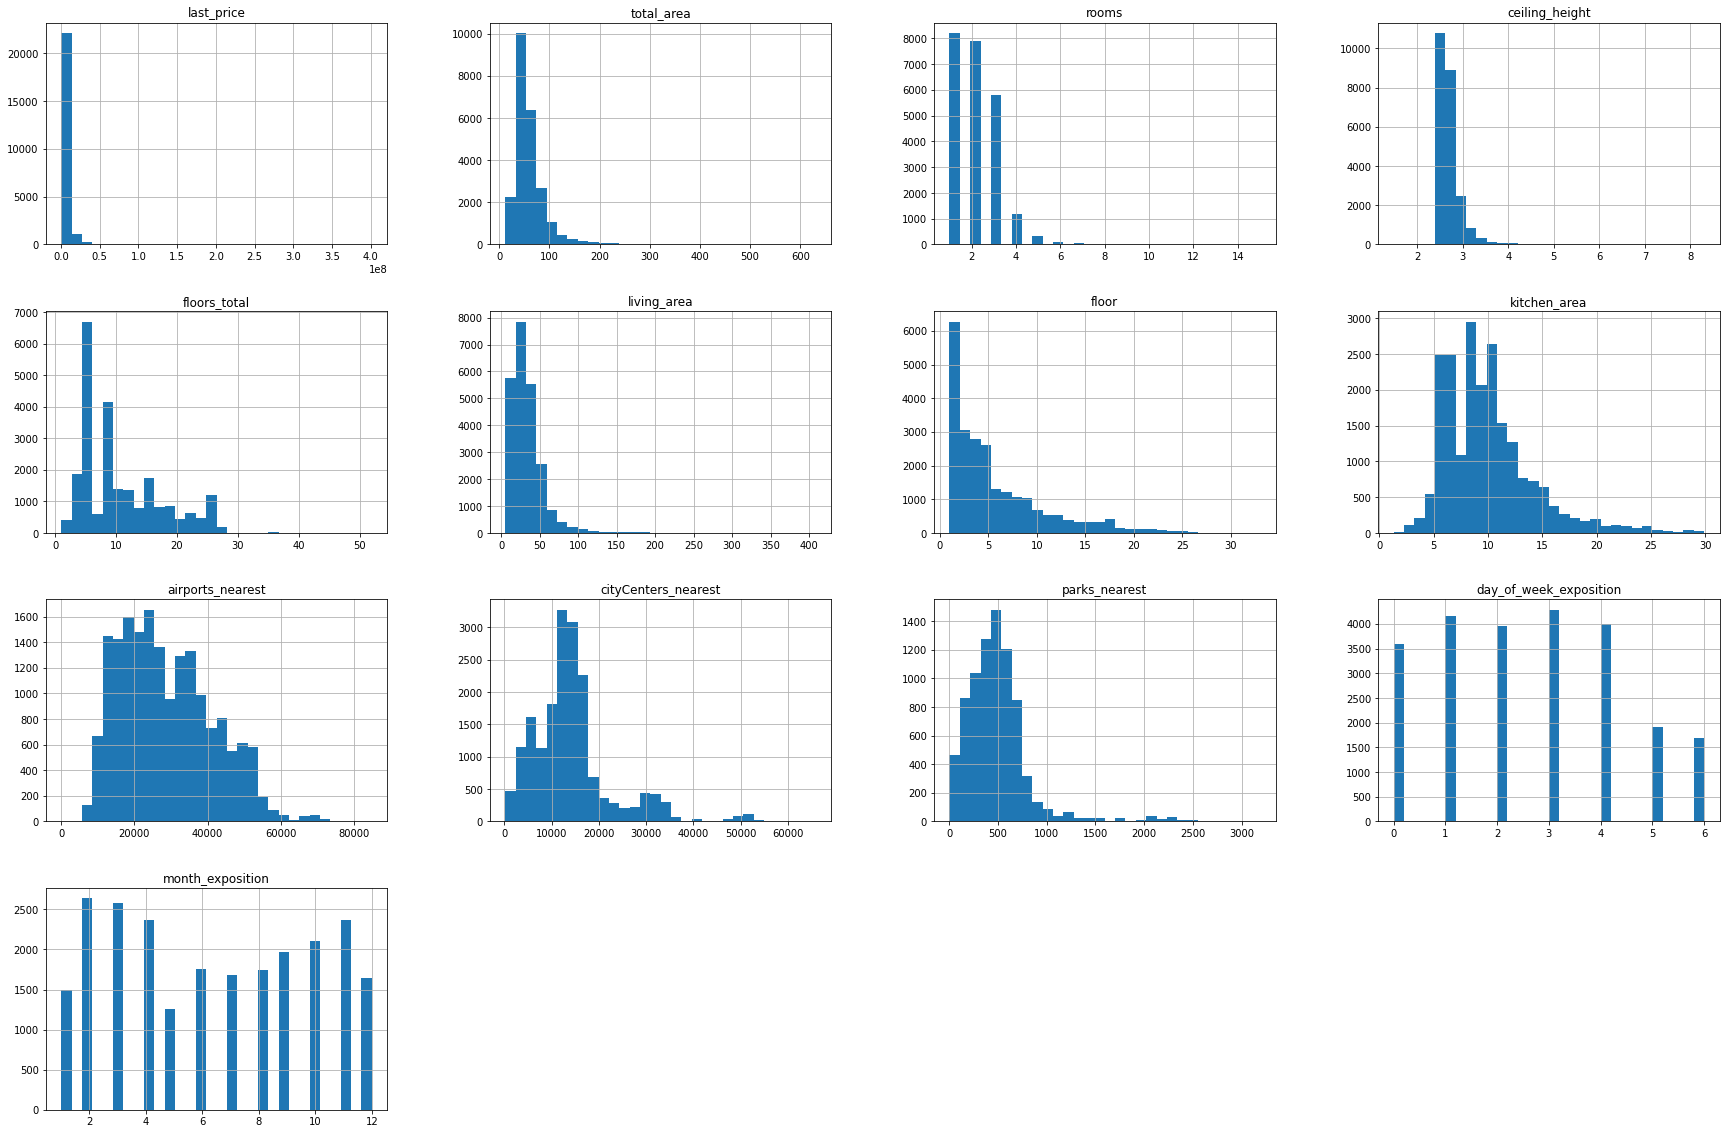

In [7]:

df2 = df[['last_price','total_area',
       'rooms','ceiling_height','floors_total', 'living_area', 'floor', 'kitchen_area',
       'airports_nearest', 'cityCenters_nearest', 'floor_type', 'parks_nearest',
       'day_of_week_exposition', 'month_exposition']]
    
df2.hist(bins=30,figsize=(30, 20))

for st in df2:
    print(df[st].describe()) #краткий анализ данных
    
#df['last_price'].hist(range = (1000000,50000000),bins=100,figsize=(20, 20)) # более детальный график для цены
#df['floor_type'].hist() # детальный график для типа этажа



общая площадь: среднее значение находится в районе 60, по графику заметно, что больше всего объектов с плошадью 50-60 м^2, поменьше до 50, а с более 200 м^2 единицы.

жилая площадь: среднее значение около 35, но по графику заметна концентрация значений в коридоре 20-30 м^2. Практически равное количество объектов с жилой площадью от 30 до 40 и до 20 м^2.

площадь кухни: в данных очень сильный разброс показателей и на графике заметны несколько пиков: 5-7 м^2, 8-9 и 10-11. Средний показатель около 10, а максимальный 30.

цена объекта: наиболее распространенная цена до 5 млн при средней в 6,5. Цена самого дорогого объекта 401 млн а дешевого - 430000.

количество комнат: больше всего на графике выделяются однокомнатные и двухкомнатные квартиры, их практически равное количество при среднем значении 2. Почти 6000 объектов имеют 3 комнаты.

высота потолков: по графику видим, что основная масса значений в коридоре 2,6-2,8. Максимальная высота зафиксирована в районе 8,3м.

этаж квартиры: большинство объектов расположены до 6 этажа, также на графике заметна скученность значений вокруг коридора 6-9.Максимум здесь 33, а среднее значение колеблется между 5 и 6.

тип этажа квартиры: на последнем и первом этаже примерно поровну объектов - около 2000. Остальные расположены на других этажах.

общее количество этажей в доме: зданий в 5 иили 9 этажей ожидаемо больше всего, а четырехэтажных примерно столько же, сколько 17-этажных. Самый выскоий объект имеет в целом 52 этажа.

расстояние до центра города в метрах: коридор 12-15 км имеет наибольшее значение на графике, прослеживается пик в районе 5 км. Объектов с показателем более 38км крайне мало.

расстояние до ближайшего аэропорта: на графике наблюдается широкий коридор 16-23 км, среднее значение хоть и находится в районе 29 км, график показывает, что на отметке 30 имеется провал чуть ниже показателей 39 км. Более 57км имеет меньшее количество объектов.

расстояние до ближайшего парка: больше всего объектов с показателем 500м (среднее значение тоже в районе данной отметки), меньше всего объектов с дистанцией до парка более 1 км.
  
день и месяц публикации объявления: меньше всего объявлений появляются в выходные, во вторник и четверг - больше всего. Весной наблюдаются пики по публикациям, объемы которых которые падают к маю, и прослеживается положительная динамика публикаций с конца весны по декабрь.

Среднее значение: 180.90355603448276
Медиана: 95.0


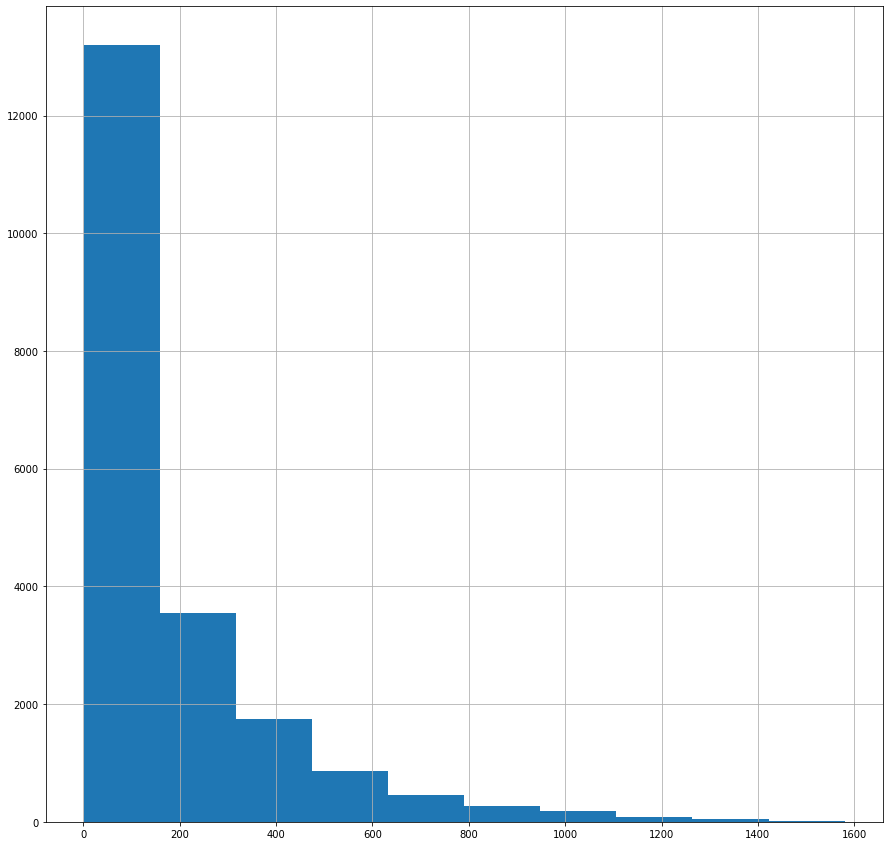

In [8]:
#Изучаем, как быстро продавались квартиры (столбец days_exposition). 
df['days_exposition'].hist(figsize=(15, 15)) #гистограмма
de_mean=df['days_exposition'].mean() 
de_med=df['days_exposition'].median()
print(f'Среднее значение: {de_mean}')
print(f'Медиана: {de_med}')




Судя по графику, объект удается продать в пределах года, причем быстрая продажа происходит за количество дней, близкое к среднему показателю здесь, то есть менее, чем за 6 месяцев. Необычно долгими можно назвать продажи с периодом от 2-2.5 лет.

                        last_price  total_area  living_area  kitchen_area  \
last_price                1.000000    0.694760     0.623840      0.256700   
total_area                0.694760    1.000000     0.945775      0.392124   
living_area               0.623840    0.945775     1.000000      0.279022   
rooms                     0.394651    0.762263     0.832830      0.176442   
kitchen_area              0.256700    0.392124     0.279022      1.000000   
day_of_week_exposition   -0.002357   -0.006123    -0.005613     -0.010656   
month_exposition         -0.002582    0.003320    -0.001215      0.022854   
year_exposition          -0.047729   -0.080039    -0.072656     -0.052996   

                           rooms  day_of_week_exposition  month_exposition  \
last_price              0.394651               -0.002357         -0.002582   
total_area              0.762263               -0.006123          0.003320   
living_area             0.832830               -0.005613         -0.0012

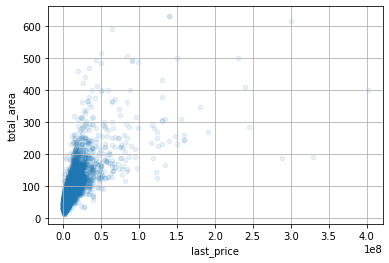

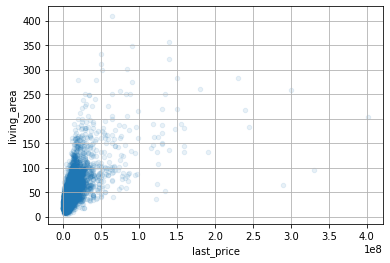

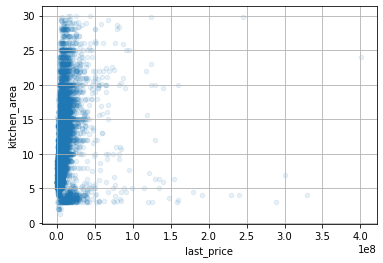

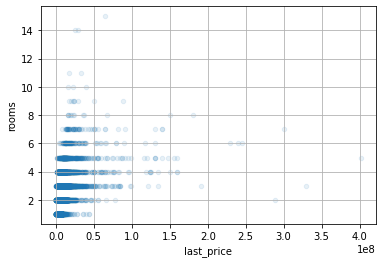

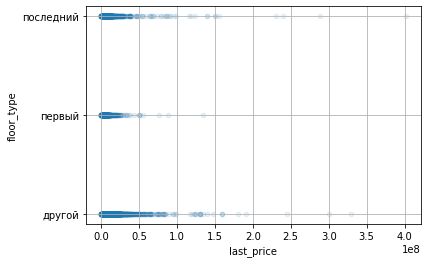

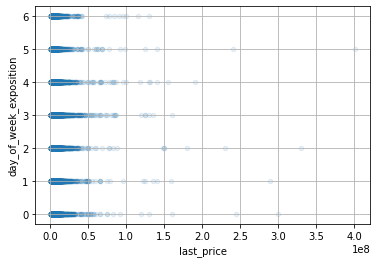

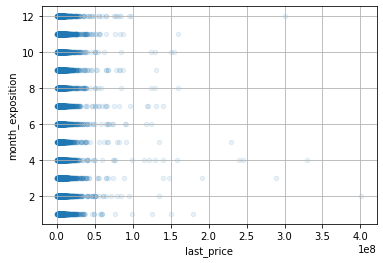

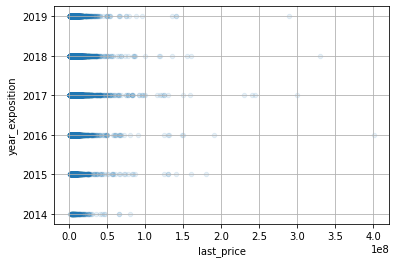

In [9]:

col3=['total_area','living_area','kitchen_area','rooms','floor_type','day_of_week_exposition','month_exposition','year_exposition']

for gu in col3:
    df.plot(x='last_price',y=gu, grid=True,kind='scatter',alpha=0.1) #построение графиков для параметров

pr_cor=df[['last_price','total_area','living_area','kitchen_area','rooms','floor_type','day_of_week_exposition','month_exposition','year_exposition']]
print(pr_cor.corr().sort_values(by='last_price',ascending=False)) #матрица корреляции

#pd.plotting.scatter_matrix(pr_cor, figsize=(9, 9)) # матрица рассеивания


**Зависимость цены от:**

1) общей площади 

Наибольший коэф. коррелляции 0.69 указывает на то, что из данных параметров решающее влияние на цену оказывает общая площадь объекта. На графике заметно, что все больше дорогих квартир появляется с ростом общей площади.

2) жилой площади

Второй по значимости параметр, что логично исходя из предыдущего наблюдения. График имеет еще больший разброс по цене с ростом жилой площади, но в целом можно говорить о положительной тенденции.

3) площади кухни

Наименьший, близкий к нулю коэф. коррелляции 0.26 из невременных параметров указывает на то, что площадь кухни меньше всего влияет на конечную цену объекта по сравнению с другими не временными показателями. На каждом отрезке площади на графике есть свои аномально высокие ценовые показатели, поэтому общую тенденцию выделить сложно. Однако можно отметить, что большинство самых дорогих объектов имеют невысокий показатедль площади кухни (до 10 м^2).

4) количества комнат

Здесь наблюдаем неодназначные результаты. До показателя 5 комнат фиксируем положительный тренд по цене объекта, однако далее тенденция обрывается к самым низким уровням. Это происходит из-за того, что в выборке нерепрезентативное число объектов с количеством комнат более 5. В связи с этим и коэф. коррелляции имеет низкое значеие 0.36.

5) этажа, на котором расположена квартира (первый, последний, другой)

На графике очевидная картинка: объекты на первом этаж имеют меньшую стоимость. Последний этаж также негативно влияет на цену, однако важно иметь ввиду, что превалирующее распределение самых дорогих объектов на других этажах достигнуто в том числе благодаря меньшинству объектов на крайних этажах в выборке.

6) даты размещения (день недели, месяц, год)

Графики показывают, что зависимость цены от временных показателей размещения выражена крайне слабо. Это подтверждают близкие к нулю коэффициенты коррелляции, однако есть две заметные особенности: с 2014 года цены на объекты выросли, по воскресеньям публикуются преимущественно менее дорогие объекты. 


In [10]:
local_top=df.pivot_table(index='locality_name', values='m2_price',aggfunc=['count','mean'])
local_top.columns = ['quantity', 'm2_price']
local_top.sort_values(by='quantity',ascending=False).head(10) # средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
local_top_new=local_top.query('quantity>=129') #сохраняем топ-10
local_top_max=local_top_new[local_top_new['m2_price']==local_top_new['m2_price'].max()]# Найдем строку с максимальным значением
local_top_min=local_top_new[local_top_new['m2_price']==local_top_new['m2_price'].min()]# Найдем строку с минимальным значением
print(local_top_max) # Выведем строку с максимумом на экран
print(local_top_min) # Выведем строку с минимумом на экран
local_top.sort_values(by='quantity',ascending=False).head(10)

                 quantity       m2_price
locality_name                           
Санкт-Петербург     15634  114685.509079
               quantity      m2_price
locality_name                        
Выборг              235  58238.143141


,quantity,m2_price
locality_name,,
Санкт-Петербург,15634,114685.509079
поселок Мурино,551,85601.120803
поселок Шушары,439,78551.344545
Всеволожск,397,68719.320400
Пушкин,369,103125.819291
Колпино,338,75424.579098
поселок Парголово,327,90175.913458
Гатчина,307,68746.146763
деревня Кудрово,299,92473.547576


В Санкт-Петербурге самая высокая цена м^2 - 114825.1, в то время как в Выборге самая низкая - 58238.1.
В Санкт-Петербурге в десятки раз больше объявлений, чем у преследователей в рейтинге - 15639. В топ-10 по объявлениям замыкает таблицу Выборг с показателем 235.

/tmp/ipykernel_224/395219825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spb['price_km']=spb['last_price']/spb['cityCenters_km'] #создаем стоолбец с ценой за км


<AxesSubplot:xlabel='last_price', ylabel='price_km'>

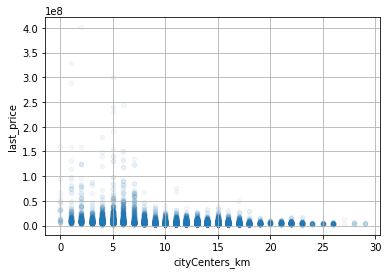

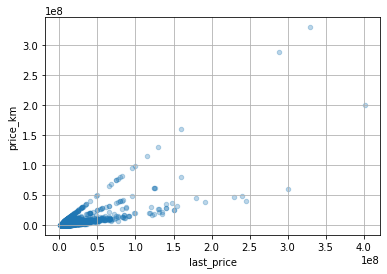

In [11]:
spb=df.query('locality_name=="Санкт-Петербург"') # создаем и сохраняем нужный срез
spb['price_km']=spb['last_price']/spb['cityCenters_km'] #создаем стоолбец с ценой за км
spb.plot(y='last_price',x='cityCenters_km', grid=True,kind='scatter',alpha=0.05) #график зависимости цены от расстояния до центра
spb.plot(x='last_price',y='price_km', grid=True,kind='scatter',alpha=0.3) #график зависимости цены от цены за км

На графике видно, что чем дальше объект от центра, тем его цена ниже, причем самые дорогие объекты удалены от центра города не более, чем на 7-8 км. Примечательно, что в коридоре 10-15 км цены не сильно варьируются.

### Общий вывод

Таким образом, в результате исследования были выыявлены следующие особенности рынка недвижимости в указанном регионе:

Больше всего объектов с общей плошадью 50-60 м^2, жилой площадью 20-30 м^2, площадью кухни около 10 м^2, ценой до 6 млн, с 1-2 комнатами, с высотой потолков 2,6-2,8, на этаже 6-9, с расстоянием до центра города 12-15 км, до аэропорта 16-23 км, до парка 500м.

Цена самого дорогого объекта более 400 млн, а дешевого - 430 тыс.

Крайне мало объектов с площадью более 400 м^2, на этаже выше 30, с дистанцией до парка более 1 км.

Выявлено, что меньше всего объявлений появляются в выходные, во вторник и четверг - больше всего. Весной наблюдаются пики по публикациям, объемы которых которые падают к маю, и прослеживается положительная динамика публикаций с конца весны по декабрь.

В основном объект удается продать в пределах года. Со временем появляется больше дорогих объектов как и количество объявлений на ресурсе, особенно с невысокой ценой.

Цена объекта больше всего зависит от общей и жилой площади - зависимость прямая. Меньше всего цена зависит от площади кухни, однако можно отметить, что большинство самых дорогих объектов имеют невысокий показатедль площади кухни (до 10 м^2).

Чем дальше объект от центра, тем его цена ниже, причем самые дорогие объекты удалены от центра города не более, чем на 7-8 км.

Объекты на первом и последнем этажах имеют меньшую стоимость.

Объявлений с числом комнат более 6 меньше всего.

В Санкт-Петербурге самая высокая цена м^2 - 115654.19, в то время как во Всеволожске самая низкая - 67434.6.  В Санкт-Петербурге в десятки раз больше объявлений, чем у преследователей в рейтинге - 10095.
